### Introduction

In this practical we will move on and discuss best practices for building and training models on real world data. We will use a dataset consisting of Amharic digits (1-9). We will develop develop a deep, fully-connected ("feed-forward") neural network model that can classify these images. In the process we will discuss:<br>

* Data collection and preparation
* Implementing Deep feed forward Neural networks
  - Libraries
  - Reading Data with data generators
      - Data augmentation
* Transfer Learning



In [0]:
import keras
from keras_preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, Activation
from keras.optimizers  import RMSprop, SGD, Adam
from keras.losses import sparse_categorical_crossentropy
import matplotlib.pyplot as plt
import numpy as np
import os
from keras import models
import cv2

## Data Generators

**Motivation**

Data preparation is required when working with neural network and deep learning models. Increasingly data augmentation is also required on more complex object recognition tasks.

Like the rest of Keras, the image augmentation API is simple and powerful.

Keras provides the *ImageDataGenerator* class that defines the configuration for image data preparation and augmentation. This includes capabilities such as:



*   Sample-wise standardization.
*   Feature-wise standardization.
*  ZCA whitening.
*   Random rotation, shifts, shear and flips.
*  Dimension reordering.
*  Save augmented images to disk.





In [41]:
## Using the ImageDataGenerator to: Provide a validation split of 20% of the data rescale the images, perform augmentation 
datagen = ImageDataGenerator(validation_split=0.2,
                             rescale=1./255 ,
                             shear_range=0.2,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             fill_mode='nearest',
                             horizontal_flip=True)

### Specify directory containing amharic dataset
TRAIN_DIR = 'amharic'


## Use train generator to create train data from entire dataset
train_generator = datagen.flow_from_directory(
    TRAIN_DIR, 
    subset='training',
        target_size=(200, 200),
        batch_size=32,
        class_mode='categorical'
)

# use validation_generator to create dataset from 20% of the data
validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    subset='validation',
        target_size=(200, 200),
        batch_size=32,
        class_mode='categorical'
)

Found 95 images belonging to 9 classes.
Found 18 images belonging to 9 classes.


# Data Description

Dataset consists of images of Amharic numbers mostly extracted from the internet. The Idea here is to train a machine learning model, specifically a deep convolutional neural network to learn to recognize the amharic numbers.

## Data preparation

The images were rescaled to 200x200 px with the help of the data generators. 

### Note:

In this tutorial, the dataset was not standardized as in the MNIST dataset, an additional task is to use the lessons learnt from the computer vision class to standardize the dataset to have consistent backgrounds like that from the MNIST dataset.

![alt text](https://conx.readthedocs.io/en/latest/_images/MNIST_6_0.png)






# Amharic Number system

Ethiopic numerals have a familiar quality about them that seems to catch the eye and pique the imagination of the first-time viewer. In particular, the bars above and below the letter-like symbols appear reminiscent of their Roman counterparts. The symbols in between the bars, however, are clearly not of Roman origin. The shapes appear Ethiopic but only half seem to correspond to Ethiopic syllables and in an incomprehensible order.

![alt text](https://www.geez.org/Numerals/images/NumberTable2-cropped.gif)

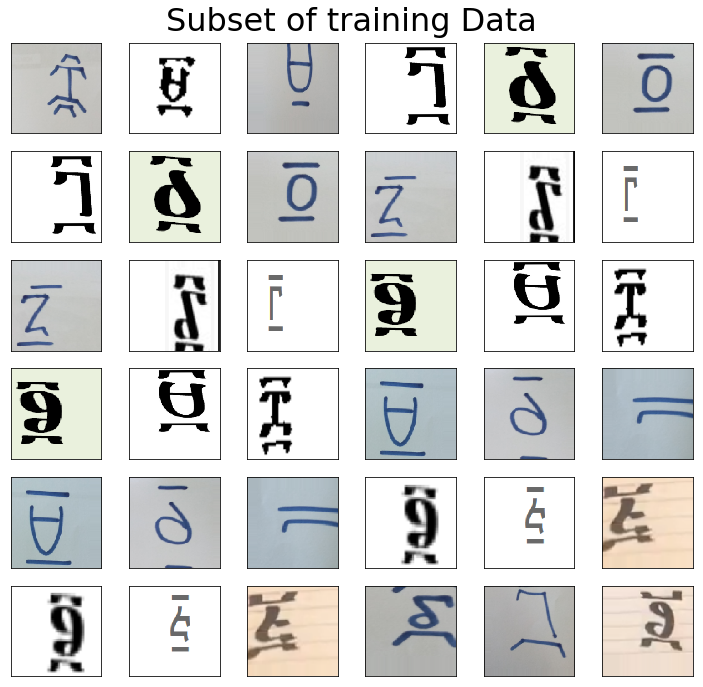

In [42]:


def plot_images(img_gen, img_title):
    fig, ax = plt.subplots(6,6, figsize=(10,10))
    plt.suptitle(img_title, size=32)
    plt.setp(ax, xticks=[], yticks=[])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    for (img, label) in img_gen:
        for i in range(6):
            for j in range(6):
                if i*6 + j < 256:
                    ax[i][j].imshow(img[i*3 + j])
        break

plot_images(train_generator, "Subset of training Data")

In [0]:
!mkdir preview

img = load_img('amharic/1/Annotation 2019-05-23 124618.png')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

# Computer Vision 

First we will cover non deep learning approaches used to pre-process and analyse images 



**1.   Otsu Thresholding**

Segment out the actual image


A technique used to create a binary image that can be used in a fully connected network model
Create image resized to fit into a CNN



In [0]:
from skimage.filters import threshold_otsu

amharic = './amharic/3/Annotation 2019-05-23 125407.png'

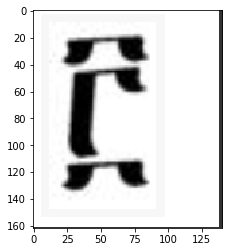

In [45]:
img = cv2.imread(amharic)
imggray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)

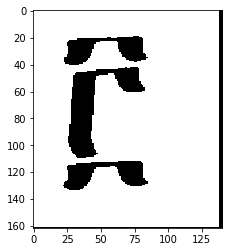

In [46]:
# Get threshold from image
threshold_value = threshold_otsu(imggray)
img_background = imggray > threshold_value


bimage = img_background.astype(np.int)
bimage2 = img_background.astype(np.uint8)
plt.imshow(bimage2, cmap='gray')


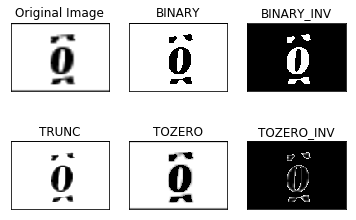

In [22]:
img = cv2.imread('amharic/4/Annotation 2019-05-23 125039.png',0)
ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(img,127,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO_INV)

titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]

for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

### 2. Edge Detection



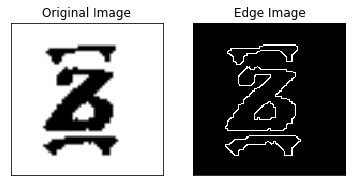

In [23]:
img = cv2.imread('amharic/6/Annotation 2019-05-23 125918.png',0)
edges = cv2.Canny(img,100,200)

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

## 3. Template Matching

Template Matching is a method for searching and finding the location of a template image in a larger image. OpenCV comes with a function cv2.matchTemplate() for this purpose. It simply slides the template image over the input image (as in 2D convolution) and compares the template and patch of input image under the template image. Several comparison methods are implemented in OpenCV. (You can check docs for more details). It returns a grayscale image, where each pixel denotes how much does the neighbourhood of that pixel match with template.


### 3.1 Single Object template Matching

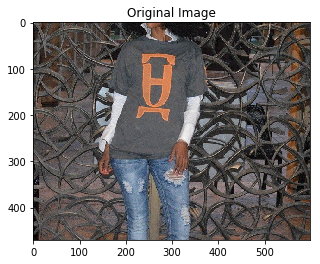

In [64]:
image = cv2.imread('geez_number.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.show()

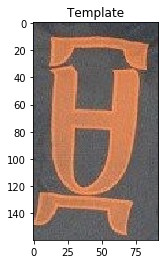

In [65]:
template = cv2.imread('geez_template.jpg')
plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
plt.title("Template")
plt.show()

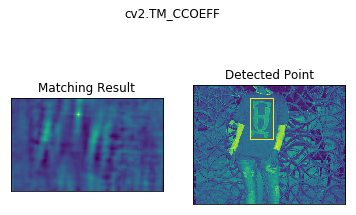

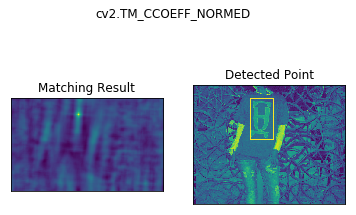

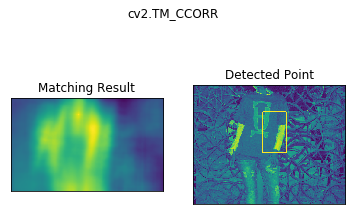

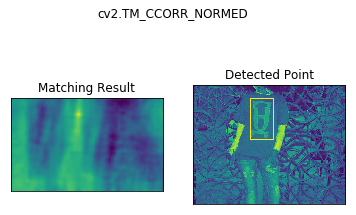

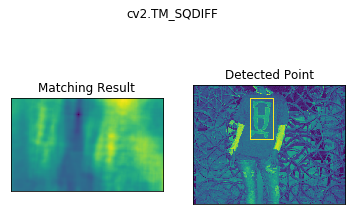

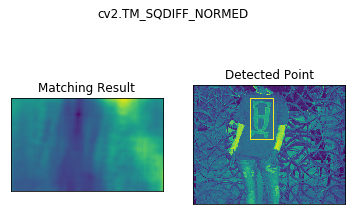

In [66]:
img = cv2.imread('geez_number.jpg',0)
img2 = img.copy()
template = cv2.imread('geez_template.jpg',0)
w, h = template.shape[::-1]

# All the 6 methods for comparison in a list
plt.imshow(img)
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

for meth in methods:
    img = img2.copy()
    method = eval(meth)

    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    cv2.rectangle(img,top_left, bottom_right, 255, 2)

    plt.subplot(121),plt.imshow(res)
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img)
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)

    plt.show()

###  3.2 Multiple Object Template Matchin

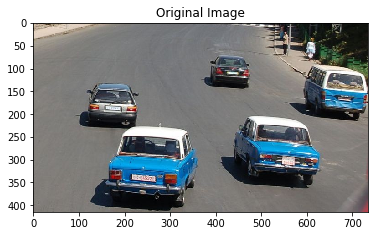

In [67]:
image = cv2.imread('taxis.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.show()

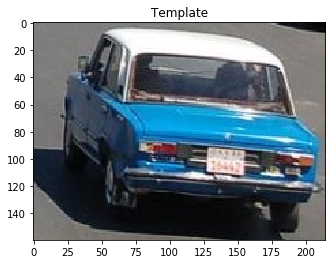

In [69]:
template = cv2.imread('taxis_template_2.jpg')
plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
plt.title("Template")
plt.show()

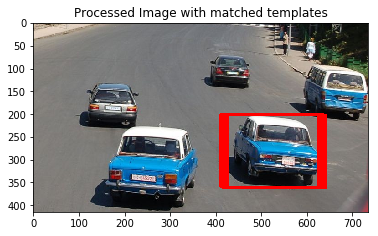

In [76]:
img_rgb = cv2.imread('taxis.jpg')
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
template = cv2.imread('taxis_template_2.jpg',0)
w, h = template.shape[::-1]

res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)
threshold = 0.8
loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

cv2.imwrite('res.png',img_rgb)

processed_image = plt.imread('res.png')
plt.title("Processed Image with matched templates")
plt.imshow(processed_image)

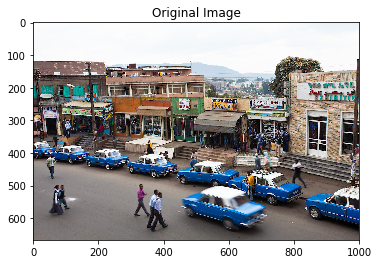

In [77]:
image = cv2.imread('taxis_2.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.show()

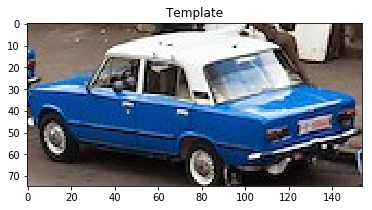

In [74]:
template = cv2.imread('taxi_template.jpg')
plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
plt.title("Template")
plt.show()

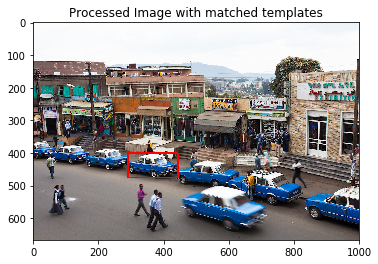

In [75]:
img_rgb = cv2.imread('taxis_2.jpg')
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
template = cv2.imread('taxi_template.jpg',0)
w, h = template.shape[::-1]

res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)
threshold = 0.8
loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

cv2.imwrite('res2.png',img_rgb)

processed_image = plt.imread('res2.png')
plt.title("Processed Image with matched templates")
plt.imshow(processed_image)


# Convolutional Neural Nets with Keras Sequential API

There are two ways to build Keras models: **sequential** and **functional**.

The sequential API allows you to create models layer-by-layer for most problems. It is limited in that it does not allow you to create models that share layers or have multiple inputs or outputs.

Alternatively, the **functional API**  allows you to create models that have a lot more flexibility as you can easily define models where layers connect to more than just the previous and next layers. In fact, you can connect layers to (literally) any other layer. As a result, creating complex networks such as siamese networks and residual networks become possible.

[Documentation](https://keras.io/getting-started/sequential-model-guide/)

[Sequential Vs Functional](https://jovianlin.io/keras-models-sequential-vs-functional/)

# Steps Involved


1.   Initialize Sequential Model
2.   Add layers (conv, Pooling, Dense, flatten etc)
3. Compile Model (Loss function, optimizer, metrics)
4. Fit Model (Means to train the model)



In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(200, 200, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(9))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 198, 198, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 97, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 97, 97, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 64)        18496     
__________

In [0]:
batch_size = 16
history = model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800 // batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
125/125 [==============================] - 46s 364ms/step - loss: 2.2660 - acc: 0.1270 - val_loss: 2.1976 - val_acc: 0.1056
Epoch 2/50
125/125 [==============================] - 38s 307ms/step - loss: 2.1230 - acc: 0.1800 - val_loss: 2.1956 - val_acc: 0.1233
Epoch 3/50
125/125 [==============================] - 40s 320ms/step - loss: 2.0463 - acc: 0.2182 - val_loss: 2.1697 - val_acc: 0.1422
Epoch 4/50
125/125 [==============================] - 40s 323ms/step - loss: 1.9005 - acc: 0.2925 - val_loss: 2.1469 - val_acc: 0.1911
Epoch 5/50
125/125 [==============================] - 40s 319ms/step - loss: 1.7748 - acc: 0.3444 - val_loss: 2.0834 - val_acc: 0.2144
Epoch 6/50
125/125 [==============================] - 39s 308ms/step - loss: 1.6230 - acc: 0.4071 - val_loss: 2.0261 - val_acc: 0.2900
Epoch 7/50
125/125 [==============================] - 40s 316ms/step - loss: 1.5100 - acc: 0.4432 - val_loss: 1.9231 - val_acc: 0.3133
Epoch 8

In [0]:
### Save weights
model.save_weights('first.h5')

# Transfer Learning

Transfer learning is a machine learning technique where a model trained on one task is re-purposed on a second related task.

## Transfer Learning with Image Data
It is common to perform transfer learning with predictive modeling problems that use image data as input.

This may be a prediction task that takes photographs or video data as input.

For these types of problems, it is common to use a deep learning model pre-trained for a large and challenging image classification task such as the ImageNet 1000-class photograph classification competition.

The research organizations that develop models for this competition and do well often release their final model under a permissive license for reuse. These models can take days or weeks to train on modern hardware.

These models can be downloaded and incorporated directly into new models that expect image data as input.



 [More info](https://machinelearningmastery.com/transfer-learning-for-deep-learning/)
 
 
 ![alt text](https://cdn-images-1.medium.com/max/1600/1*9GTEzcO8KxxrfutmtsPs3Q.png)

In [0]:
from keras.applications import VGG16

# VGG 16

![alt text](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

In [0]:
# Use imagenet weights
vgg_conv = VGG16(weights='imagenet',
                include_top = False, 
                input_shape = (200,200,3))

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 4s 0us/step


In [0]:
vgg_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

In [0]:
### Add our custom laters

tr_model = vgg_conv.output
tr_model = Flatten()(tr_model)
tr_model = Dense(64, activation='relu')(tr_model)
tr_model = Dropout(0.5)(tr_model)
tr_model = Dense(9, activation='softmax')(tr_model)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
new_model = models.Model(inputs=vgg_conv.input, outputs=tr_model)

# Freezing and Fine-tuning vgg16

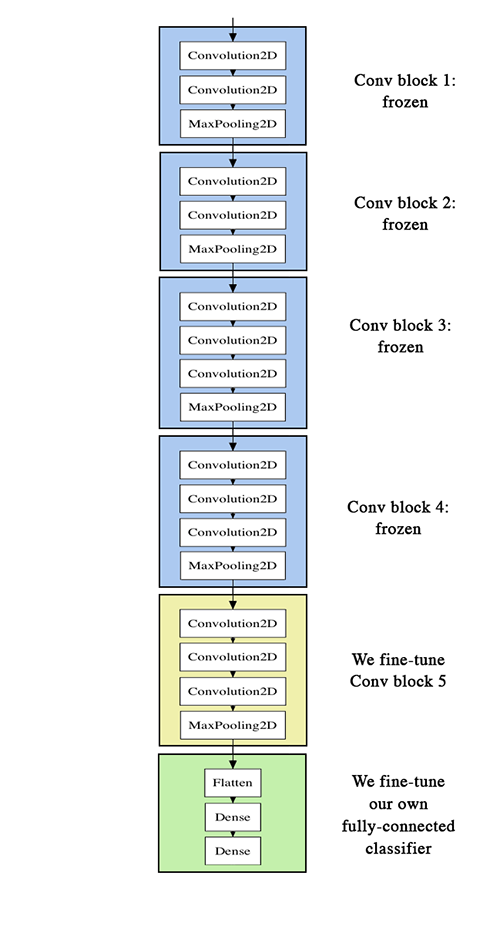

In [0]:
def print_layer_trainable():
    for layer in new_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [0]:
for i, layer in enumerate(new_model.layers):
    print(i, layer.name)

0 input_2
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 flatten_2
20 dense_3
21 dropout_2
22 dense_4


In [0]:
for layer in new_model.layers[:18]:
    layer.trainable = False
for layer in new_model.layers[18:]:
    layer.trainable = True

In [0]:
print_layer_trainable()

False:	input_2
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
True:	block5_pool
True:	flatten_2
True:	dense_3
True:	dropout_2
True:	dense_4


In [0]:
new_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
history = new_model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800 // batch_size)

Epoch 1/50
125/125 [==============================] - 49s 391ms/step - loss: 2.2662 - acc: 0.1765 - val_loss: 1.9555 - val_acc: 0.2978
Epoch 2/50
125/125 [==============================] - 43s 348ms/step - loss: 1.8748 - acc: 0.2395 - val_loss: 1.6836 - val_acc: 0.4144
Epoch 3/50
125/125 [==============================] - 42s 337ms/step - loss: 1.6959 - acc: 0.3216 - val_loss: 1.4831 - val_acc: 0.4722
Epoch 4/50
125/125 [==============================] - 43s 348ms/step - loss: 1.5186 - acc: 0.4015 - val_loss: 1.2469 - val_acc: 0.5578
Epoch 5/50
125/125 [==============================] - 44s 353ms/step - loss: 1.2423 - acc: 0.5065 - val_loss: 1.0319 - val_acc: 0.7711
Epoch 6/50
125/125 [==============================] - 43s 343ms/step - loss: 1.0721 - acc: 0.5712 - val_loss: 0.8763 - val_acc: 0.7200
Epoch 7/50
125/125 [==============================] - 43s 345ms/step - loss: 0.9445 - acc: 0.6178 - val_loss: 0.6730 - val_acc: 0.7922
Epoch 8/50
125/125 [==============================] - 4

In [0]:
new_model.save('transfer_model.h5')

In [0]:
from keras.models import load_model
new_model = load_model('transfer_model.h5')

Instructions for updating:
Use tf.cast instead.


# Visualization

In [0]:
test_files = validation_generator.filenames

In [0]:
def get_test_batch(root_path,img_paths):
    return np.array([cv2.resize(cv2.imread(os.path.join(root_path,t)),(200,200)) for t in img_paths]), np.array([l.split("\\")[0] for l in img_paths])

In [0]:
batch, labels = get_test_batch(TRAIN_DIR, test_files)

In [0]:
preds = new_model.predict_on_batch(batch)

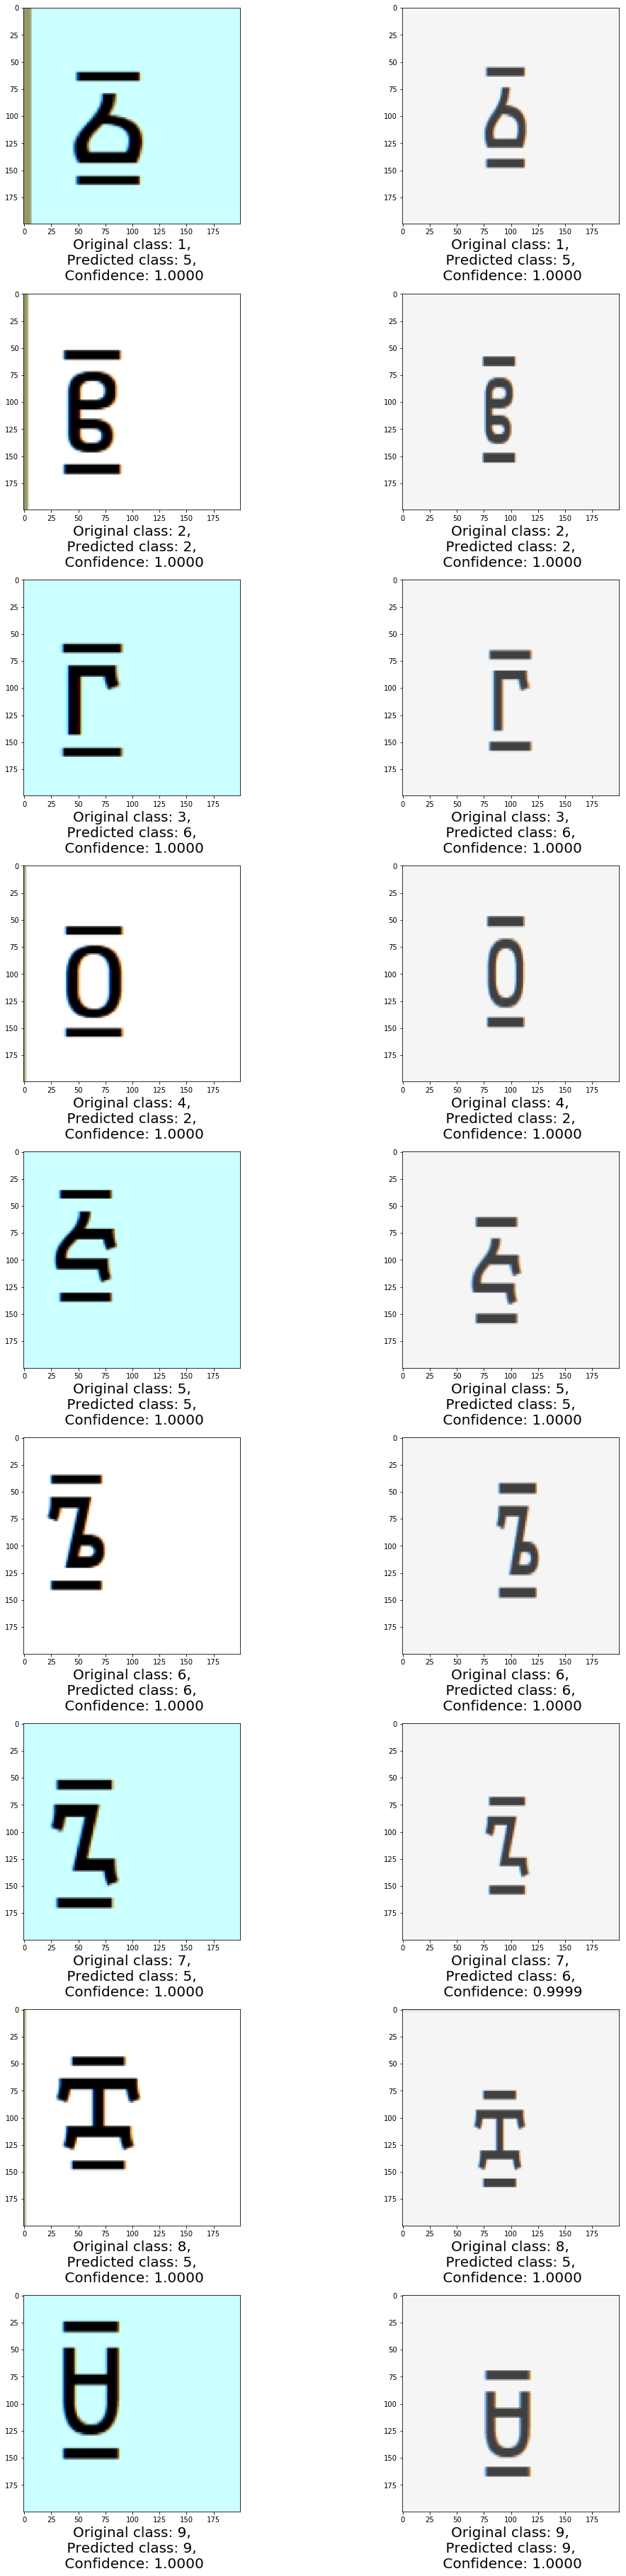

In [0]:
plt.figure(figsize=(15,100))
count = 1
for img,orig_img in zip(preds,batch):
    plt.subplot(batch.shape[0],2,count)
    plt.imshow(orig_img)
    plt.xlabel('Original class: {},\n Predicted class: {}, \n Confidence: {:.4f}'.format(
        labels[count-1],
        np.argmax(img)+1,
        img[np.argmax(img)]), fontsize=20)
    plt.tight_layout()
    
    count+=1